In [1]:
import pandas as pd
import os
import preprocessing_pipeline as pppp
import librosa
import yaml
from main import *

In [2]:
# pip install pandas numpy scikit-learn librosa soundfile tqdm noisereduce pyyaml

In [3]:
dir_fsc22

'../data/fsc22'

In [4]:
df_fsc22 = pd.read_csv(os.path.join(dir_fsc22,'metadata.csv'))
df_fsc22 

,Source File Name,Dataset File Name,Class ID,Class Name
0,17548__A.wav,1_10101.wav,1,Fire
1,17548_B.wav,1_10102.wav,1,Fire
2,17548_C.wav,1_10103.wav,1,Fire
3,17548_D.wav,1_10104.wav,1,Fire
4,17548_E.wav,1_10105.wav,1,Fire
...,...,...,...,...
2020,164882__timsc__squirrel-call.wav,27_12771.wav,27,Squirrel
2021,162648__cognito-perceptu__park-bench-atmospher...,27_12772.wav,27,Squirrel
2022,122260__echobones__angry-squirrel-long.wav,27_12773.wav,27,Squirrel
2023,82828__noisecollector__angrysquirrel-creepingt...,27_12774.wav,27,Squirrel


In [5]:
df_fsc22.loc[0,'Dataset File Name']

'1_10101.wav'

In [6]:
test_file = os.path.join(dir_fsc22,'audio',df_fsc22.loc[0,'Dataset File Name'])
test_file

'../data/fsc22\\audio\\1_10101.wav'

In [7]:
signal,sr = read_signal(test_file,sr=None)

In [8]:
signal.shape

(220500,)

In [9]:
sr

44100

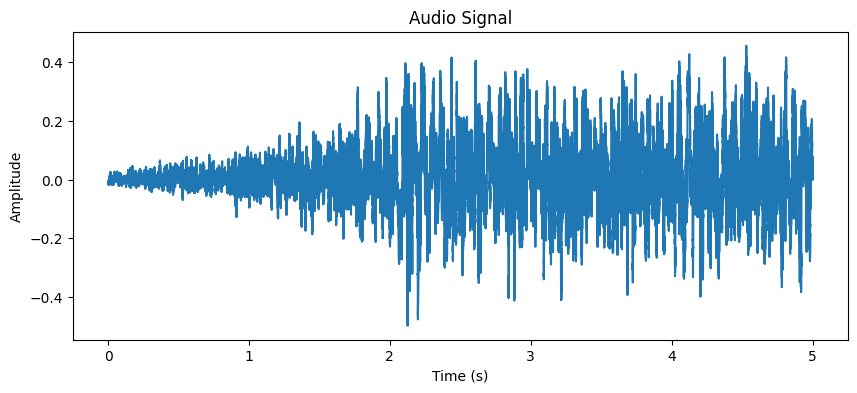

In [10]:
import matplotlib.pyplot as plt

# Create a time axis in seconds
time = range(len(signal))
time = [t / sr for t in time]

# Plot the audio signal
plt.figure(figsize=(10, 4))
plt.plot(time, signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.show()

In [11]:
import IPython.display as ipd

ipd.Audio(test_file)

In [12]:
# pppp.process_audio(signal,sr)

spectrogram, melspectrogram, mfcc = pppp.process_audio(
    signal, sr, length=5, n_fft=2048, n_mels=256, n_mfcc=20, denoise=False
)

In [13]:
spectrogram.shape

(1025, 431)

In [14]:
melspectrogram.shape

(256, 431)

In [15]:
mfcc.shape

(20, 431)

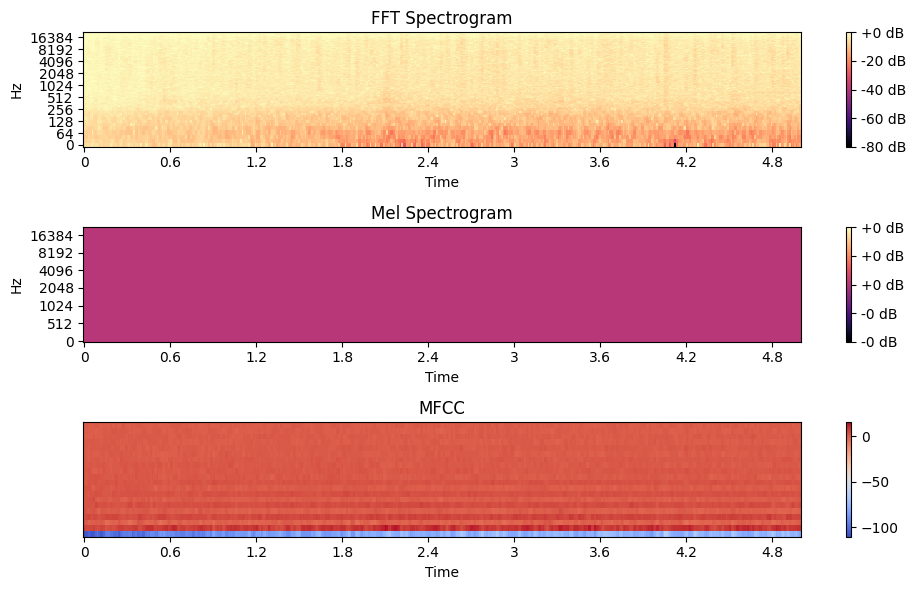

In [16]:
import matplotlib.pyplot as plt
import librosa.display

# Plot the FFT spectrogram
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                         sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('FFT Spectrogram')

# Plot the mel spectrogram
plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.power_to_db(melspectrogram, ref=np.max),
                         sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

# Plot the MFCC
plt.subplot(3, 1, 3)
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')

# Display the plots
plt.tight_layout()
plt.show()


In [17]:
sample_rate = 44100
segment_length = 5
n_fft = 4410
n_mels = 128
n_mfcc = 20
denoise = False

params_path = "params.yml"
with open(params_path, "r") as file:
    params = yaml.safe_load(file)

algo = params["algorithm"]
batch_size = int(algo["params"]["batch_size"])
n_epochs = 50
patience = int(algo["params"]["patience"])
learning_rate = 0.01

model_dir = "./model/cnn"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_save_path = os.path.join(model_dir, "model.pkl")

demo_model_path = "./model/demo"
if not os.path.exists(demo_model_path):
    os.makedirs(demo_model_path)

device = get_cuda_device()

# # CNN
# PATH = "./model/basecnn200"
# model_set = torch.load(f"{PATH}/model.pt")
# clf_pre = model_set["model"]

In [18]:
os.path.join(dir_fsc22,'audio')

'../data/fsc22\\audio'

In [19]:
import librosa
import argparse
import pandas as pd
import numpy as np
import pickle as pkl 
import torch
import torchaudio
import torchvision
from PIL import Image

sample_rate = 44100
segment_length = 5
n_fft = 4410
n_mels = 128
n_mfcc = 20
denoise = False
data_dir = os.path.join(dir_fsc22,'audio')

def extract_spectrogram(values, clip, entries):
	for data in entries:

		num_channels = 3
		window_sizes = [25, 50, 100]
		hop_sizes = [10, 25, 50]
		centre_sec = 2.5

		specs = []
		for i in range(num_channels):
			window_length = int(round(window_sizes[i]*sample_rate/1000))
			hop_length = int(round(hop_sizes[i]*sample_rate/1000))

			clip = torch.Tensor(clip)
			spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=4410, win_length=window_length, hop_length=hop_length, n_mels=128)(clip)
			eps = 1e-6
			spec = spec.numpy()
			spec = np.log(spec+ eps)
			spec = np.asarray(torchvision.transforms.Resize((128, 250))(Image.fromarray(spec)))
			specs.append(spec)
		new_entry = {}
		new_entry["audio"] = clip.numpy()
		new_entry["values"] = np.array(specs)
		new_entry["target"] = data["target"]
		values.append(new_entry)

def extract_features(audios):
	audio_names = list(audios.filename.unique())
	values = []
	for audio in audio_names:
		clip, sr = librosa.load(os.path.join(data_dir, audio), sr=sample_rate)
		entries = audios.loc[audios["filename"]==audio].to_dict(orient="records")
		extract_spectrogram(values, clip, entries)
		print("Finished audio {}".format(audio))
	return values


In [20]:
df_fsc22.rename(columns={'Dataset File Name': 'filename'}, inplace=True)
df_fsc22.rename(columns={'Class ID': 'target'}, inplace=True)


In [21]:
df_fsc22[:5]

,Source File Name,filename,target,Class Name
0,17548__A.wav,1_10101.wav,1,Fire
1,17548_B.wav,1_10102.wav,1,Fire
2,17548_C.wav,1_10103.wav,1,Fire
3,17548_D.wav,1_10104.wav,1,Fire
4,17548_E.wav,1_10105.wav,1,Fire


In [22]:
prep = extract_features(df_fsc22[:5])
type(prep)

Finished audio 1_10101.wav
Finished audio 1_10102.wav
Finished audio 1_10103.wav
Finished audio 1_10104.wav
Finished audio 1_10105.wav


list

In [23]:
prep[0]['values'].shape

(3, 128, 250)

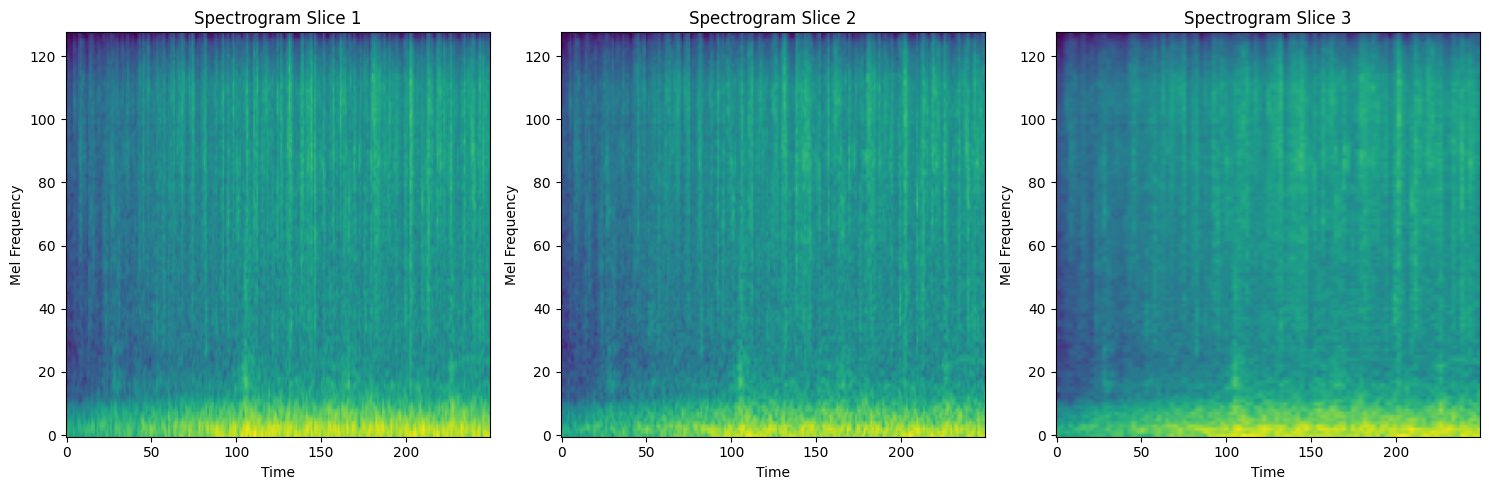

In [24]:
import matplotlib.pyplot as plt
x = prep[0]['values']
# Assuming x is your 3D Mel spectrogram with shape (3, 128, 250)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each slice (along the first dimension)
for i in range(x.shape[0]):
    # Display the spectrogram slice
    axes[i].imshow(x[i, :, :], aspect='auto', origin='lower')
    axes[i].set_title(f'Spectrogram Slice {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Mel Frequency')

plt.tight_layout()
plt.show()

In [25]:
df_fsc22

,Source File Name,filename,target,Class Name
0,17548__A.wav,1_10101.wav,1,Fire
1,17548_B.wav,1_10102.wav,1,Fire
2,17548_C.wav,1_10103.wav,1,Fire
3,17548_D.wav,1_10104.wav,1,Fire
4,17548_E.wav,1_10105.wav,1,Fire
...,...,...,...,...
2020,164882__timsc__squirrel-call.wav,27_12771.wav,27,Squirrel
2021,162648__cognito-perceptu__park-bench-atmospher...,27_12772.wav,27,Squirrel
2022,122260__echobones__angry-squirrel-long.wav,27_12773.wav,27,Squirrel
2023,82828__noisecollector__angrysquirrel-creepingt...,27_12774.wav,27,Squirrel


In [26]:
df_fsc22['target'] = df_fsc22['target']-1

In [27]:
from sklearn.model_selection import train_test_split
validation_size = 0.05
# Assuming df_fsc22 is your DataFrame and 'target' is the column for stratification
df_train, df_test = train_test_split(df_fsc22, test_size=validation_size, stratify=df_fsc22['target'], random_state=42)

In [28]:
df_test

,Source File Name,filename,target,Class Name
1816,212764__qubodup__lion-roar.wav,25_12517.wav,24,Lion
1091,432606__nicstage__distant-gunshot.wav,15_11542.wav,14,Gunshot
1661,33378__coppersmith-barbet__yellowwarbler1 (1)3...,23_12312.wav,22,BirdChirping
1121,353093__jg-booysen__sfx-pistol-gunshot.wav,15_11572.wav,14,Gunshot
2015,254271__philllchabbb__squirrel.wav,27_12766.wav,26,Squirrel
...,...,...,...,...
1294,245041__kwahmah-02__pub-ambience-1.wav,18_11820.wav,17,Speaking
1164,545549__rsellick__machete-table-metal-wood-cla...,16_11640.wav,15,WoodChop
905,164275_(2)_Carpentry - sawing timber with hand...,13_11306.wav,12,Handsaw
1954,18515_(5)_cognito-perceptu__squirrel-upset.wav,27_12705.wav,26,Squirrel


In [30]:
num_epochs = 50

In [31]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import ResNet34_Weights
# Assuming the extract_features function has been run and 'values' is available


# Define a custom dataset
class AudioDataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        sample = self.features[idx]
        audio = sample['audio']
        image = torch.tensor(sample['values'], dtype=torch.float32)
        target = torch.tensor(sample['target'], dtype=torch.long)
        return image, target







In [32]:
# Create the dataset and dataloader
features = extract_features(df_train)
train_dataset = AudioDataset(features)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

features = extract_features(df_test)
test_dataset = AudioDataset(features)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Finished audio 8_10873.wav
Finished audio 6_10613.wav
Finished audio 8_10844.wav
Finished audio 17_11737.wav
Finished audio 10_11039.wav
Finished audio 1_10115.wav
Finished audio 25_12534.wav
Finished audio 3_10337.wav
Finished audio 3_10339.wav
Finished audio 12_11273.wav
Finished audio 21_12159.wav
Finished audio 25_12503.wav
Finished audio 14_11422.wav
Finished audio 22_12220.wav
Finished audio 10_11066.wav
Finished audio 12_11272.wav
Finished audio 15_11566.wav
Finished audio 7_10712.wav
Finished audio 9_10947.wav
Finished audio 5_10547.wav
Finished audio 17_11751.wav
Finished audio 24_12443.wav
Finished audio 4_10406.wav
Finished audio 27_12722.wav
Finished audio 19_11962.wav
Finished audio 3_10332.wav
Finished audio 21_12120.wav
Finished audio 11_11169.wav
Finished audio 13_11372.wav
Finished audio 18_11830.wav
Finished audio 16_11623.wav
Finished audio 18_11813.wav
Finished audio 8_10810.wav
Finished audio 18_11833.wav
Finished audio 17_11720.wav
Finished audio 3_10345.wav
Finis

In [33]:
# Load the pretrained ResNet model
model = models.resnet34(weights=ResNet34_Weights.DEFAULT)  # Replace with the correct function to load ResNet38

# Modify the final layer to output 27 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 27)

# Move the model to the GPU if available
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
model.train()
for epoch in range(num_epochs):  # Set the number of epochs
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 2.0699232425846037
Epoch 2, Loss: 1.338282998468055
Epoch 3, Loss: 1.2224685354310958
Epoch 4, Loss: 0.9186559651718765
Epoch 5, Loss: 0.7597278503120922
Epoch 6, Loss: 0.7748789000706594
Epoch 7, Loss: 0.6069508830054862
Epoch 8, Loss: 0.616726930024194
Epoch 9, Loss: 0.49646940656372757
Epoch 10, Loss: 0.4174794874718932
Epoch 11, Loss: 0.31062519562537555
Epoch 12, Loss: 0.25163428986170255
Epoch 13, Loss: 0.26082745334896884
Epoch 14, Loss: 0.2661540061235428
Epoch 15, Loss: 0.2730391717470083
Epoch 16, Loss: 0.3000199511402943
Epoch 17, Loss: 0.3864243305364593
Epoch 18, Loss: 0.1865188917297809
Epoch 19, Loss: 0.2920800587315051
Epoch 20, Loss: 0.223412245023446
Epoch 21, Loss: 0.1760387914713289
Epoch 22, Loss: 0.23874970128545997
Epoch 23, Loss: 0.323979093464183
Epoch 24, Loss: 0.12970461862802993
Epoch 25, Loss: 0.10823181021928055
Epoch 26, Loss: 0.14844112594413464
Epoch 27, Loss: 0.21782264844743443
Epoch 28, Loss: 0.3073039641756503
Epoch 29, Loss: 0.100288

In [34]:
# Define the directory where you want to save the model
model_dir = './model'

# Create the directory if it does not exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define the path for the pickle file
model_path = os.path.join(model_dir, 'trained_model.pth')

# Save the model state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to ./model\trained_model.pth


In [36]:
import torch
from torchvision import models
from torch import nn

# Recreate the model architecture
model = models.resnet34(weights=None)  # Replace with the correct function to load ResNet34 without pretrained weights
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 27)  # Assuming 27 is the number of classes

# Load the saved model parameters
model_path = './model/trained_model.pth'
model.load_state_dict(torch.load(model_path))

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Put the model in evaluation mode
model.eval()

# Initialize a list to store the predictions
predictions = []

# Perform predictions on the test data
with torch.no_grad():
    for inputs,_ in test_loader:
        inputs = inputs.to(device)  # Move inputs to the appropriate device

        # Forward pass to get outputs
        outputs = model(inputs)

        # Get the predicted classes
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# predictions now contains the predicted class indices for the test data


In [40]:
predicted.to('cpu')

tensor([18,  5,  4, 24,  3, 11])

In [45]:
# Validate the model
# Recreate the model architecture
model = models.resnet34(weights=None)  # Replace with the correct function to load ResNet34 without pretrained weights
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 27)  # Assuming 27 is the number of classes

# Load the saved model parameters
model_path = './model/trained_model.pth'
model.load_state_dict(torch.load(model_path))

# Move the model to the GPU if available
device = get_cuda_device()
model = model.to(device)



model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# Show a validation value
validation_value = 100 * correct / total
print(f"Validation value (Accuracy): {validation_value:.2f}%")


Accuracy of the network on the test images: 82 %
Validation value (Accuracy): 82.35%


In [46]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
import numpy as np

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append the labels to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')  # Use 'micro' or 'macro' as needed
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Use 'micro' or 'macro' as needed

print(f'Accuracy of the network on the test images: {accuracy * 100:.2f}%')
print(f'Precision of the network on the test images: {precision:.2f}')
print(f'F1 Score of the network on the test images: {f1:.2f}')

Accuracy of the network on the test images: 82.35%
Precision of the network on the test images: 0.83
F1 Score of the network on the test images: 0.81


d:\001Drexel\99_hackathon\4_CODEFEST2024\Philly-Codefest\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
labels

tensor([17,  6,  1, 19, 13, 19], device='cuda:0')

In [ ]:
# df_test[['filename','target']].to_csv('./train.csv',index = False)
# import os
# import shutil

# # Define the source and destination directories
# source_dir = "../data/fsc22/audio"
# destination_dir = "../data/train"

# # Create the destination directory if it does not exist
# if not os.path.exists(destination_dir):
#     os.makedirs(destination_dir)

# # Iterate over the filenames in the df_train DataFrame
# for filename in df_test['filename']:
#     # Construct the full file path for the source and destination
#     source_file = os.path.join(source_dir, filename)
#     destination_file = os.path.join(destination_dir, filename)

#     # Move the file from the source to the destination
#     shutil.move(source_file, destination_file)

# print("Files moved successfully.")



Files moved successfully.
